# AKT3 Project - Sign Language MNIST
**Michael Burgstaller, Paul Haunschmied, Christina Rosenberger**

# Einleitung

Das Ziel unseres Projektes ist die Erkennung von Buchstaben in der Zeichensprache. Als Datensatz verwenden wir dafür [Sign Language MNIST](https://www.kaggle.com/datamunge/sign-language-mnist) von der Webseite Kaggle.

Das Jupyter-Notebook wurde von uns mithilfe von Google Colab erstellt, daher haben wir den Datensatz auf Google Drive hochgeladen um ihn einfach in das Notebook einzubinden.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
for dirname, _, filenames in os.walk('/content/drive/My Drive/sign_language_mnist'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/My Drive/sign_language_mnist/sign_mnist_test.csv
/content/drive/My Drive/sign_language_mnist/sign_mnist_train.csv


## Einbindung und Konfiguration der Bibliotheken

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout

import matplotlib.pylab as plt


## Laden der Daten

Die Daten müssen aus den `.csv` Dateien in das Notebook geladen werden. 

In [ ]:
training_dataframe = pd.read_csv("/content/drive/My Drive/sign_language_mnist/sign_mnist_train.csv")
test_dataframe = pd.read_csv("/content/drive/My Drive/sign_language_mnist/sign_mnist_test.csv")

Für die Verwendung im Notebook müssen Labels und Bilddaten getrennt werden.

In [ ]:
training_values = training_dataframe.drop(['label'], 1)
training_labels = training_dataframe['label']
test_values = test_dataframe.drop(['label'], 1)
test_labels = test_dataframe['label']

## Normalisierung der Daten

Die Bilddaten werden auf den Wertebereich `[0, 1]` normalisiert. Laut unserer Recherche, begünstigt dies eine rascherer Konvergenz des Netzwerkes.

In [ ]:
X_train = training_values.values / 255.0
X_test = test_values.values / 255.0

Für den ersten Layer unseres Netzwerkes muss das eindimensionale Bilddaten-Array in ein mehrdimensionales Array umgewandelt werden.

In [ ]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

Die Umwandlung in die one-hot Repräsentation hat nicht den gewünschten Effekt erzielt, bei unserer Recherche ist uns das aber als gängige Praxis für neuronale Netze aufgefallen. Mit der Verwendung von `SparseCategoricalAccuracy` sind die Ergebnisse schlagartig besser ausgefallen.
```py
lb=LabelBinarizer()
Y_train = lb.fit_transform(training_labels)
Y_test = lb.fit_transform(test_labels)
```


In [ ]:
Y_train = training_labels
Y_test = test_labels

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(27455, 28, 28, 1) (27455,) (7172, 28, 28, 1) (7172,)


## Aufbau des Modells

In [ ]:
model=Sequential([
  Conv2D(256,kernel_size=(5,5), strides=1,padding='same',activation='relu',input_shape=(28,28,1)),
  MaxPool2D(),
  Conv2D(128,kernel_size=(5,5), strides=1,padding='same',activation='relu'),
  MaxPool2D(),
  Conv2D(64,kernel_size=(5,5), strides=1,padding='same',activation='relu'),
  Flatten(),
  Dropout(rate=0.25),
  Dense(units=25,activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 256)       6656      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       819328    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          204864    
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dropout (Dropout)            (None, 3136)              0

## Verwendung des Modells

Bevor wir wieder zur ursprünglichen `SparseCategoricalAccuracy`gewechselt haben mussten wir aufgrund der one-hot Repräsentation folgenden Code beim Aufruf von `model.compile` verwenden.

```py
loss=tf.keras.losses.categorical_crossentropy,
metrics=[tf.metrics.CategoricalAccuracy()]
```

Nach längerem Versuchen sind wir auf den Fehler gekommen der uns bei der one-hot Repräsentation zu falschen Ergebnissen gebracht hat. Die Daten hatten Labels die im Bereich von 0 bis 25 waren um die 26 Buchstaben des Alphabets darzustellen. Da es sich bei den Buchstaben J (9) und Buchstaben Z (25) um sich bewegende Handzeichen handelt gibt es für diese Zeichen keine Bilder im Datensatz. Der `LinearBinarizer` sieht nun die vorhandenen Daten und mappt diese auf disjunkte Gruppen. Dadurch entstehen 24 unterschiedliche Klassen und die Confusion-Matrix erhält einen "Knick".

In [ ]:
# Anzahl der Epochen wurde heruntergesetzt damit Notebook schneller durchläuft. 
# Das abgegebene Netz wurde über 10 Epochen entwickelt.
epochs = 3

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=[tf.metrics.SparseCategoricalAccuracy()]
)

history = model.fit(X_train, Y_train, batch_size=500, epochs=epochs, validation_split=0.1, verbose=1, shuffle=1)

Epoch 1/3
50/50 [==============================] - 629s 13s/step - loss: 2.2923 - sparse_categorical_accuracy: 0.3120 - val_loss: 0.9360 - val_sparse_categorical_accuracy: 0.7170
Epoch 2/3
50/50 [==============================] - 631s 13s/step - loss: 0.5371 - sparse_categorical_accuracy: 0.8232 - val_loss: 0.1576 - val_sparse_categorical_accuracy: 0.9581
Epoch 3/3
50/50 [==============================] - 628s 13s/step - loss: 0.1418 - sparse_categorical_accuracy: 0.9554 - val_loss: 0.0455 - val_sparse_categorical_accuracy: 0.9905


In [63]:
# model.save('signnet_095677.h5')
# model = tf.keras.models.load_model('signnet_095677.h5')

## Evaluierung der Ergebnisse

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test,  Y_test, verbose=1)

print('Test accuracy:', test_accuracy)

225/225 [==============================] - 42s 185ms/step - loss: 0.2507 - sparse_categorical_accuracy: 0.9044
Test accuracy: 0.9043502807617188


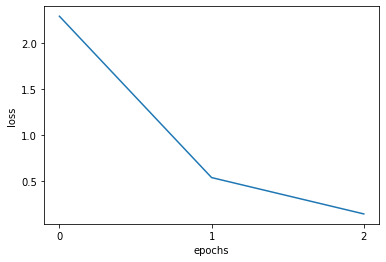

In [71]:
plt.xlabel('epochs')
plt.xticks(range(epochs))
plt.ylabel('loss')
plt.plot(history.history['loss'])
plt.title='Loss over Epochs'

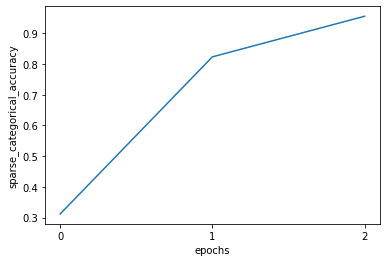

In [73]:
plt.xlabel('epochs')
plt.xticks(range(epochs))
plt.ylabel('sparse_categorical_accuracy')
plt.plot(history.history['sparse_categorical_accuracy'])
plt.title = 'Accuracy over Epochs'

Hier nun einige Beispiele und wie sie von unserem Netzwerk vorhergesagt wurden.

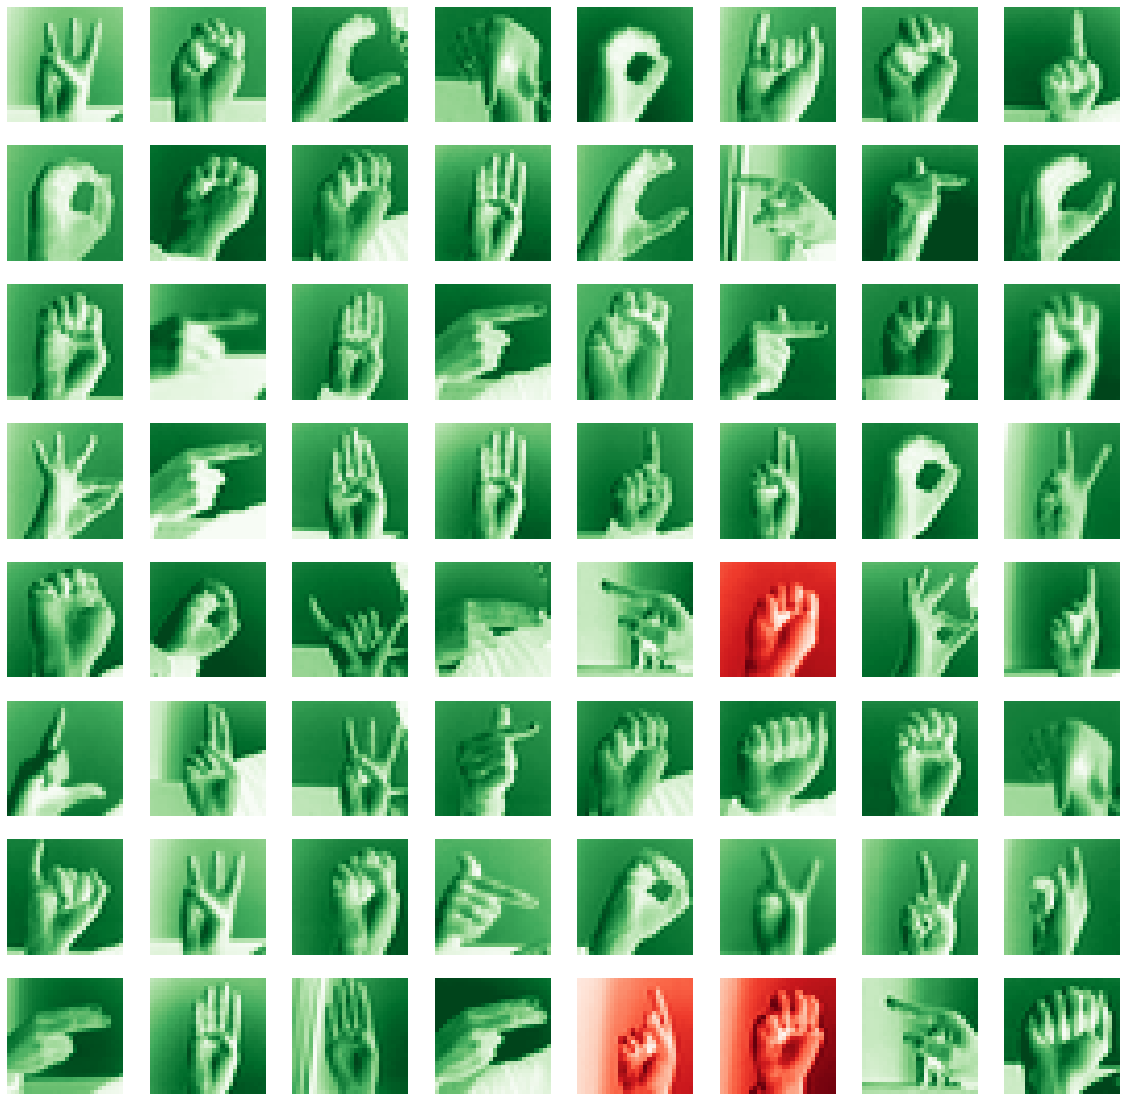

In [75]:
import matplotlib.pylab as predictions_plot

predictions_plot.figure(figsize=(20,20))
samples = np.random.choice(X_test.shape[0], size=(64,))
for i, si in enumerate(samples):
    pred = np.argmax(model(X_test[si, ...][np.newaxis, ...].astype(np.float32)))
    
    cmap  = predictions_plot.cm.Greens if pred == test_labels[si] else predictions_plot.cm.Reds
    predictions_plot.subplot(8,8, i+1)
    predictions_plot.imshow(X_test[si, :,:,0], cmap=cmap)
    predictions_plot.axis('off')
    # predictions_plot.title = "%d/%d" % (pred, test_labels[si]) # showing the title throws an error which we could not solve

## Confusion Matrix

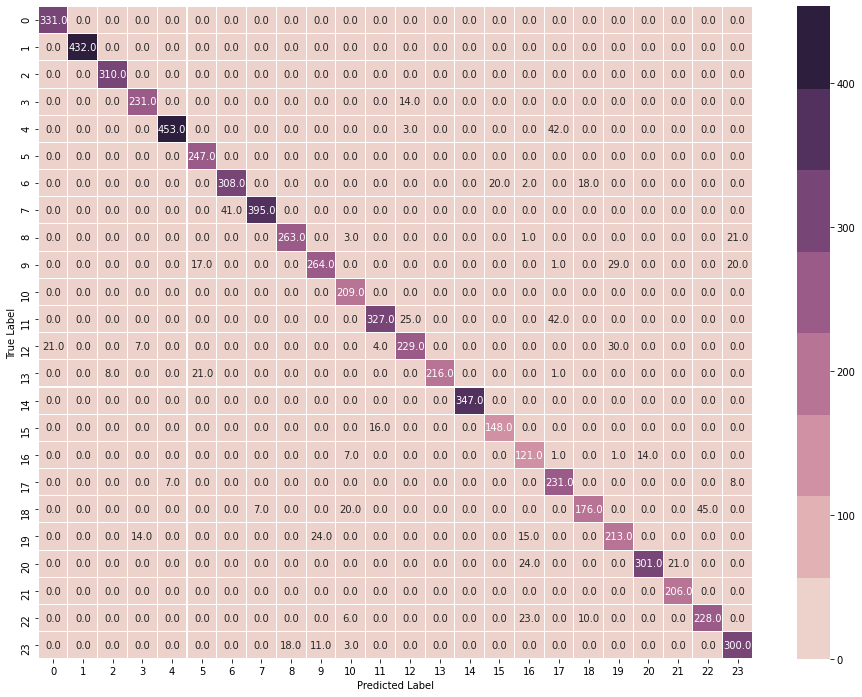

In [77]:
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix

lb=LabelBinarizer()
lb.fit(range(0,25)) # Behebung des "Knicks" in der ConfusionMatrix der aufgrund der automatischen
                    # Erkennung von Kategorien entsteht.

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(lb.transform(test_labels), axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(16, 12))

sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap=sns.cubehelix_palette(8), fmt='.1f', ax=ax)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title = "Confusion Matrix"
plt.show()